Name : LABROGERE Alexandre \
SUNET ID : 06525782

#### Importation of the packages
I will use the code in the course github repository in my implementations.

In [658]:
import os
os.chdir('/Users/Alex/Desktop/Documents_4A/Winter_quarter_1/MS&E_346/RL_book/')
import numpy as np

In [659]:
from rl.dynamic_programming import V, S, A
from rl import dynamic_programming
from rl.dynamic_programming import *

In [415]:
from rl import markov_process, markov_decision_process

In [416]:
import operator
from typing import Mapping, Iterator, TypeVar, Tuple, Dict, Iterable

import numpy as np

from rl.distribution import Categorical, Choose
from rl.iterate import converged, iterate
from rl.markov_process import NonTerminal, State
from rl.markov_decision_process import (FiniteMarkovDecisionProcess,
                                        FiniteMarkovRewardProcess)
from rl.policy import FinitePolicy, FiniteDeterministicPolicy

In [417]:
from rl.midterm_2022.priority_q import  PriorityQueue
from rl.midterm_2022 import grid_maze

In [418]:
import importlib

In [419]:
from time import time

# Question 1 : Gaps Value Iteration

In this problem we will implement the gaps-based value iteration algorithm mentioned in class.

The gaps-based iteration algorithm proceeds as follows

1. Initialize the value function to zero for all states: $v[s] = 0\ \forall s \in \mathcal{N}$
2. Calculate the gaps for each state: $g[s] = |v[s] - \max_a \mathcal{R}(s,a) + \sum_{s'} \mathcal{P}(s,a,s') \cdot v(s')|$
3. While there is some gap that exceeds a threshold
 - Select the state with the  largest gap: $s_{max} = \arg\max_{s \in \mathcal{N}} g[s]$
 - Update the value function for $s_{max}$: $v[s_{max}] = \max_a \mathcal{R}(s_{max},a) + \sum_{s'}\mathcal{P}(s_{max},a,s') \cdot v(s')$
 -  Update the gap for $s_{max}$: $g[s_{max}] = 0$
4. Return v

We will test your implementation on a grid maze MDP. We have defined this class in "grid_maze.py", you should  briefly familiarize yourself with that code. In particular pay attention to the difference in reward functions for the two classes "GridMazeMDP_Dense" and "GridMazeMDP_Sparse"

Here is how you can use the classes:

In [420]:
underlying_maze = grid_maze.Maze(10, 10)
maze_mdp = grid_maze.GridMazeMDP_Sparse(underlying_maze, 0, 0)

you can visualize the maze if you wish

In [421]:
#print(maze_mdp)

you can also visualize a policy on the mdp

In [422]:
v2_res = dynamic_programming.value_iteration_result(maze_mdp, 0.9)
print(maze_mdp.print_policy(v2_res[1]))

--------------------
|* <|v|v < < < < <|v|
| +-+ + + +-+-+-+-+ +
|^ < < <|^ <|v <|> v|
| +-+ + +-+-+ +-+-+ +
|^|> ^|^ <|v|v < <|v|
| +-+ + + + + +-+-+ +
|^|> ^|^|^ < < < < <|
| + +-+-+ +-+ + +-+ +
|^|^ <|> ^ <|^|^ <|^|
| +-+-+-+ +-+ +-+-+-+
|^ <|> > ^|> ^ < < <|
| +-+ +-+ + + +-+-+-+
|^ <|^|v|^|^|^ < < <|
|-+ +-+ + +-+-+-+ + +
|> ^ <|> ^ <|v <|^|^|
| +-+ + + +-+ + +-+-+
|^ <|^|^|^ <|v|^ < <|
| + +-+-+ + + +-+-+ +
|^|^ <|> ^|^ < < <|^|
|-+-+-+-+-+-+-+-+-+-+


You will need to make use of the PriorityQueue class in your implementation. A PriorityQueue is an ordered queue which supports the following operations
1. isEmpty(self): check if the queue is empty   
2. contains(self, element): check if the queue contains an element
3. peek(self): peek at the highest priority element in the queue    
4. pop(self): remove and return the highest priority element in the queue    
5. insert(self, element, priority): insert an element into the queue with given priority
6. update(self, element, new_priority): update the priority of an element in the queue
7. delete(self, element): delete an element from the queue

Below are some examples of using the queue

In [423]:
q: PriorityQueue = PriorityQueue()
print(q.isEmpty(), ':', "the queue is empty")
q.insert("a", 1)
print(q.isEmpty(), ':',  "the queue is not empty")
print(q.contains("a"), ':',  "the queue contains a")
print(q.contains("b"), ':',  "the queue does not contain a")
print(q.peek(), ':',  "a is the first element in the queue")
q.insert("b", 0)
print(q.contains("b"), ':',  "the queue now contains b")
print(q.peek(), ':',  "b is now at the front of the queue")
x = q.pop()
print(x, ':',  "we removed b from the queue")
print(q.isEmpty(), ':',  "the queue still nonempty")
print(q.contains("a"), ':',  "the queue still contains a")
print(q.contains("b"), ':',  "the queue does not contain b anymore")
print(q.peek(), ':',  "a is at the front of the queue")
q.insert("c", 5)
print(q.peek(), ':',  "a is still at the front of the queue")
q.update("a", 6)
print(q.peek(), ':',  "after updating a is no longer at the front of the queue")

print(q)

True : the queue is empty
False : the queue is not empty
True : the queue contains a
False : the queue does not contain a
(1, 'a') : a is the first element in the queue
True : the queue now contains b
(0, 'b') : b is now at the front of the queue
b : we removed b from the queue
False : the queue still nonempty
True : the queue still contains a
False : the queue does not contain b anymore
(1, 'a') : a is at the front of the queue
(1, 'a') : a is still at the front of the queue
(5, 'c') : after updating a is no longer at the front of the queue
(5, 'c') (6, 'a')


### Part 1 : Invert transition map

Explanation : I use the mdp.mapping method of the git repo in order to create the mapping between non terminal states and the corresponding dependent non terminal states. I need to test if the dependent state is non terminal, which may cause some lost of time, but the function still run quite quickly.

In [626]:
from collections import defaultdict
def invert_transition_map(mdp: markov_decision_process.FiniteMarkovDecisionProcess[S, A]) ->\
            Mapping[S, Iterable[S]]:
    '''
    YOUR CODE HERE
    Implement the invert_transition_map method
    '''
    inverted_mapping = {}
    for s in mdp.non_terminal_states: #We create the inverted map for non terminal states
        l_state=set() #List of the dependent states : I USE A SET TO NOT HAVE REDONDANT STATES
        for a in mdp.actions(s): #We look at the actions possible and then 
            for (s1,r),_ in mdp.mapping[s][a]: #We look at all the states we can get to
                if (s1 in mdp.non_terminal_states): #Just add the non terminal states (There may be something more efficient to test if the state is non terminal)
                    l_state.add(s1)
            
        inverted_mapping[s] = list(l_state) #I TRANSFORM THE SET BACK IN A LIST
    '''END YOUR CODE'''
    return inverted_mapping

### Part 2
Explanation : 

For the gaps_value_iteration function, I initialize the value function to be zero, then during the update phase I pop the state with biggest gap (his gap will be updated to zero so we can get it out of the list). I then update the value function using same as in dynamic_programming repo. I then look at all the dependent states, update their gaps accordingly. If the gap is bigger than the threshold (or 0) -> if in the queue I update, otherwise I insert in the queue. I use the inverse of the gap in the queue so that the biggest gap brings to the front of the queue. If the update makes the gap zero (or below threshold), I delete the state.

For the gaps_value_iteration_result wrapper, I use the hint by only adding to the queue the element that have positive (i.e. bigger than treshold) gaps. For the criterion, I just need to check the element with the biggest gap of the queue, and I also account for th rare occasions where the gaps queue could be empty (because I pop/delete some elements).

In [630]:
def gaps_value_iteration(
    mdp: markov_decision_process.FiniteMarkovDecisionProcess[S, A],
    gamma: float, 
    gaps: PriorityQueue) -> Iterator[V[S]]:
    '''
    Calculate the value function (V*) of the given MDP by applying the
    update function repeatedly until the values converge.
    '''
    dependency_map = invert_transition_map(mdp)
    v_0: V[S] = {s: 0.0 for s in mdp.non_terminal_states}
    
        
    def update(v: V[S]) -> V[S]:
        '''
        YOUR CODE HERE
        perform a single update to v for the state with the largest gap
        update the gaps for any dependent states
        '''
        e = 1e-6 #Very small value to update the gap if zero
        s = gaps.pop() #s is the state with the biggest gap
        v[s] = max(mdp.mapping[s][a].expectation(lambda s_r: s_r[1] + gamma * extended_vf(v, s_r[0])) for a in mdp.actions(s)) #We update value for max state
        for s1 in dependency_map[s]: #For dependent states we update the gap (the priority on the queue is 1/gap)
            g = abs(v[s1] - max(mdp.mapping[s1][a].expectation(lambda s_r: s_r[1] + gamma * extended_vf(v, s_r[0])) for a in mdp.actions(s1))) #We calculate new gaps for dependent states
            if gaps.contains(s1):
                if g>0:
                    gaps.update(s1, 1/g)
                else :
                    gaps.delete(s1)
            else:
                if g>0:
                    gaps.insert(s1, 1/g) #Update gaps with inverse priority
        
        #raise NotImplementedError 
        '''END YOUR CODE'''
        return v

    
    return iterate(update, v_0)


def gaps_value_iteration_result(
    mdp: FiniteMarkovDecisionProcess[S, A],
    gamma: float
) -> Tuple[V[S], FiniteDeterministicPolicy[S, A]]:
    
    gaps = PriorityQueue()
    
    '''
    YOUR CODE HERE
    instantiate the value function and populate the gaps
    ''' 
    e=1e-6
    v_0: V[S] = {s: 0.0 for s in mdp.non_terminal_states}
    for s in mdp.non_terminal_states :
        g = abs( v_0[s] - max(mdp.mapping[s][a].expectation(lambda s_r: s_r[1] + gamma * extended_vf(v_0, s_r[0])) for a in mdp.actions(s)) ) #We calculate initial gaps
        if g>e:
            gaps.insert(s, 1/g) #Biggest number -> lowest priority in those queues so I use the inverse
    #raise NotImplementedError
    ''' END YOUR CODE ''' 
    
    def criterion(x,y): #x and y are v value functions on non terminal states
        '''
        YOUR CODE HERE
        implement the criterion for convergence of the value function 
        '''
        tolerance = 1e-5# Threshold
        '''
        MODIFIED : THIS IS THE CODE THAT WORKS
        list_gap=[]
        for s in mdp.non_terminal_states:
            list_gap.append(abs( x[s] - max(mdp.mapping[s][a].expectation(lambda s_r: s_r[1] + gamma * extended_vf(x, s_r[0])) for a in mdp.actions(s)) ))
        return max(list_gap) < tolerance # Infinity norm
        '''
        if gaps.isEmpty():
            return True
        else :
            u,s = gaps.peek()
            g = 1/u
            return g<tolerance
        #raise NotImplementedError
        ''' END YOUR CODE ''' 

    
    opt_vf: V[S] = converged(
        gaps_value_iteration(mdp, gamma, gaps),
        done = criterion 
    )
        
    opt_policy: markov_decision_process.FiniteDeterministicPolicy[S, A] = dynamic_programming.greedy_policy_from_vf(
        mdp,
        opt_vf,
        gamma
    )

    return opt_vf, opt_policy

# Do not change the code below here, just run it

## Calculating the VF for a maze with sparse rewards

In [631]:
underlying_maze = grid_maze.Maze(50, 50)
maze_mdp = grid_maze.GridMazeMDP_Sparse(underlying_maze, 0, 0)

#### printing the runtime for the calculation

In [633]:
start = time()
v1_res = gaps_value_iteration_result(maze_mdp, 0.9)
print(time() - start)

4.207993030548096


In [634]:
start = time()
v2_res = dynamic_programming.value_iteration_result(maze_mdp, 0.9)
print(time() - start)

3.6009199619293213


#### confirming that the value functions are identical

In [635]:
assert v1_res[1] == v2_res[1]

#### The values are identical : the code works !

However the gaps value iteration takes a little bit more time than synchronous value iteration algorithm in that example.

The gaps_value_iteration is approximately 1.1 times slower than the synchronous value_iteration in my case, for a maze of size (50,50). More precision next part.

## Calculating the VF for a maze with dense rewards

In [636]:
underlying_maze = grid_maze.Maze(50, 50) 
maze_mdp = grid_maze.GridMazeMDP_Dense(underlying_maze, 0, 0)

#### printing the runtime for the calculation

In [637]:
start = time()
v1_res = gaps_value_iteration_result(maze_mdp, 1)
print(time() - start)

13.62431526184082


In [638]:
start = time()
v2_res = dynamic_programming.value_iteration_result(maze_mdp, 1)
print(time() - start)

3.7727062702178955


#### confirming that the value functions are identical

In [639]:
assert v1_res[1] == v2_res[1]

#### The values are identical : the code works !

The difference in time is more important in that case : more precision on time differences in the next part.

### Differences in convergence time :

Observations on the (50,50) Maze : 
- The Gaps Value Iteration are little more longer than synchronous algorithms in both cases 
- The Synchronous algorithms takes the same time in both the Sparse and Dense cases
- The Gaps Value Iteration takes much more time in the dense Case than in the Sparse case

Explanation : 
- For synchronous algorithms, the whole value function is updated at each time, so the sparse and dense cases are virtually the same.
- For the asynchronous algorithm, we update gaps by gaps, so the Sparse case is quicker because there are less non-zero gaps, less gaps to be updated and dependent gaps. On the other hand for the dense case, more states are added to the queue so we end up making a lot more iterations.

Intuition : 
- I believe that in the sparse case, the gaps_value_iteration should be more rapid than the value_iteration in the Sparse case (for "small" mazes), and on the contrary the value_iteration should be faster in the dense case
- I also believe that the time of convergence asynchronous algorithms should grow more with the size of the maze than the synchronous algorithms

To prove those points, I have made graphics with different sizes of maze :

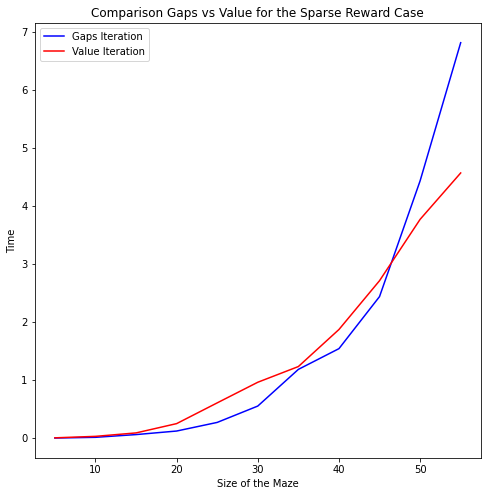

In [640]:
#Sparse Reward Case
import matplotlib.pyplot as plt
sizes = [5,10,15,20,25,30,35,40,45,50,55]

l_gap = []
l_val = []
for s in sizes:
    underlying_maze = grid_maze.Maze(s, s)
    maze_mdp = grid_maze.GridMazeMDP_Sparse(underlying_maze, 0, 0)
    
    t1_start = time()
    v1_res = gaps_value_iteration_result(maze_mdp, 0.9)
    t1_end = time()
    l_gap.append(t1_end - t1_start)
    
    t2_start = time()
    v2_res = dynamic_programming.value_iteration_result(maze_mdp, 0.9)
    t2_end = time()
    l_val.append(t2_end - t2_start)

plt.figure(figsize = (8,8))
plt.plot(sizes, l_gap, color = 'blue', label='Gaps Iteration')
plt.plot(sizes, l_val, color = 'red', label='Value Iteration')
plt.xlabel("Size of the Maze")
plt.ylabel("Time")
plt.title("Comparison Gaps vs Value for the Sparse Reward Case")
plt.legend(loc='best')
plt.show()

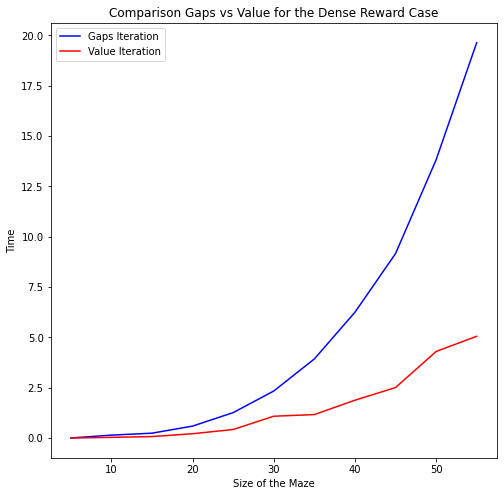

In [641]:
#Dense Reward Case
import matplotlib.pyplot as plt
sizes = [5,10,15,20,25,30,35,40,45,50,55]

l_gap_dense = []
l_val_dense = []
for s in sizes:
    underlying_maze = grid_maze.Maze(s, s)
    maze_mdp = grid_maze.GridMazeMDP_Dense(underlying_maze, 0, 0)  
    
    t1_start = time()
    v1_res = gaps_value_iteration_result(maze_mdp, 1)
    t1_end = time()
    l_gap_dense.append(t1_end - t1_start)
    
    t2_start = time()
    v2_res = dynamic_programming.value_iteration_result(maze_mdp, 1)
    t2_end = time()
    l_val_dense.append(t2_end - t2_start)

plt.figure(figsize=(8,8))
plt.plot(sizes, l_gap_dense, color = 'blue', label='Gaps Iteration')
plt.plot(sizes, l_val_dense, color = 'red', label='Value Iteration')
plt.xlabel("Size of the Maze")
plt.ylabel("Time")
plt.title("Comparison Gaps vs Value for the Dense Reward Case")
plt.legend(loc='best')
plt.show()

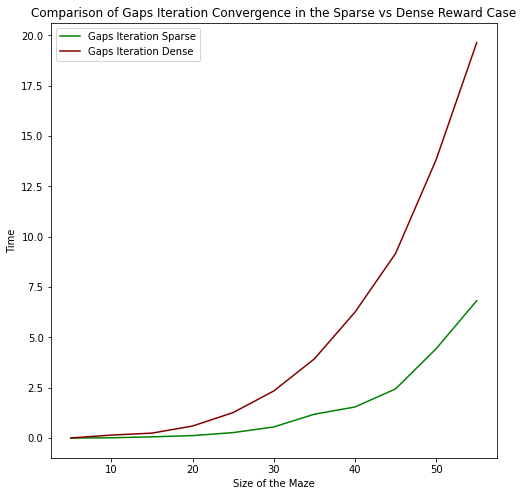

In [642]:
#Dense Reward Case
import matplotlib.pyplot as plt
sizes = [5,10,15,20,25,30,35,40,45,50,55]


plt.figure(figsize=(8,8))
plt.plot(sizes, l_gap, color = 'green', label='Gaps Iteration Sparse')
plt.plot(sizes, l_gap_dense, color = 'maroon', label='Gaps Iteration Dense')
plt.xlabel("Size of the Maze")
plt.ylabel("Time")
plt.title("Comparison of Gaps Iteration Convergence in the Sparse vs Dense Reward Case")
plt.legend(loc='best')
plt.show()

#### Final observations :

- For a small maze, in the Sparse case, the gaps_value_iteration is actually quicker to converge than the value_iteration, however the time of convergence grows more with the size of the maze, and when we get to (50,50), the value_iteration is faster.
- On the other hand, the classical algorihtm is always faster in the Dense case, and the gaps_value_iteration time of convergence explodes with the size of the maze
- The time of convergence of the dynamic_programming.value_iteration does not depend of the dense/sparse cases

# Question 2 :  Dynamic Asset Allocation

### 1) Optimization on the utility function for T=1

We have :  $$W_1 = (1-\pi)W_0 X_1 + \pi W_0 Y_1$$

and 

$$\begin{cases}
  U(W_1) = \log{((1-\pi)W_0)} & \text{with probability } 1/2 \\    
  U(W_l) = \log{(\pi W_0 2^{i})} & \text{with probability } 1/2^{i}, i \in \mathbb{Z}^+\\
\end{cases}$$

Thus $$E[U(W_1)] = 1/2 \times (\log(1-\pi)+\log(W_0)) + \sum_{i=1}^\infty 1/2^{i} \times (i\log(2) + \log(\pi) + \log(W_0))$$

We obtain that $$\frac{\partial E[U(W_1)]}{\partial \pi} = 1/2 * \frac{-1}{1-\pi} + 1/2 * 1/\pi $$

Setting that derivative to zero, we obtain that $$\pi^* = 1/2$$

### Optimization for T>1

#### Introduction and notations

We are looking to optimize $U(W_T) = log(W_T)$.
We consider a finite horizon, with discount factor $\gamma = 1$. Let define D the joint distribution of (X,Y) at each time step.

We are thus trying to optimize $E[log(W_T)/(t,W_t)]$ over $\pi_t \in [0,1]$, knowing that $(X_{t+1},Y_{t+1})$ follows D.

The reward is 0 for t = 0,...,T-1 ; and the reward is $log(W_T)$ for t=T.

We have $W_{t+1} = (1-\pi_t)W_t X_{t+1} + \pi_t W_t Y_{t+1}$,

and we define the value function as $V_t^{\pi}(W_t) = E_{\pi}[log(W_T)/(t,W_t)]$

Let's look at the Optimal Value Function, and use the Bellman Optimality Equation to write :

For $t<T-1$, $$V_t^*(W_t) = \max_{\pi_t} \{E_{(X_{t+1},Y_{t+1})\sim D}[V_{t+1}^*(W_{t+1})]\}$$

and $$V_{T-1}^*(W_{T-1}) = max_{\pi_{T-1}} \{E_{(X_{T},Y_{T})\sim D}[log(W_{T})]\}$$

To solve for the Optimal Value Function (and the Optimal Policy), we are going to use a backward induction, i.e. work our way backward from the last time step. In the course reader, we made an "educated guess" for the form of the value function, but here I will not do it. The result that $\pi_t^* = \pi^*$ at each time step will come from the fact that the Utility function is logarithm, and that the joint distribution is independent of time. We will use a backward induction.

#### Base case :

Let's look at the time step T-1, and plug the relation between $W_T$ and $W_{T-1}$ :
$$V_{T-1}^*(W_{T-1}) = max_{\pi_{T-1}} \{E_{(X_{T},Y_{T})\sim D}[log((1-\pi)W_{T-1} X_{T} + \pi W_{T-1} Y_{T})]\}$$

But we know that $$E_{(X_{T},Y_{T})\sim D}[log((1-\pi)W_{T-1} X_{T} + \pi W_{T-1} Y_{T})] = 1/2 \times (\log(1-\pi_{T-1})+\log(W_{T-1})) + \sum_{i=1}^\infty 1/2^{i} \times (i\log(2) + \log(\pi_{T-1}) + \log(W_{T-1})) $$

Solving for the maximum over $\pi_{T-1}$ give the same result as in 1) : $$\pi_{T-1}^* = \pi^* = 1/2$$
Using that value of $\pi_{T-1}^*$, and the facts that $log(ab) = log(a)+log(b)$ and $\sum_{i=1}^{\infty} 1/2^{i+1} = 1/2$, we can deduce that :
$$V_{T-1}^*(W_{T-1}) = cste + log(W_{T-1})$$
The constant that appears here does depend on the value of $W_{T-1}$.

The key point is that in the constant will $\textbf{not}$ play a role in determining the optimal policy value in the equation $$V_t^*(W_t) = \max_{\pi_t} \{E_{(X_{t+1},Y_{t+1})\sim D}[V_{t+1}^*(W_{t+1})]\}$$

Hence we can prove by backward induction that for all $t \in \{T-1, T-2, ... , 1\}$, $V_t^*(W_t) = cste + log(W_t)$ and $\pi_t^* = 1/2$

#### Heredity :

We have just proven the base case, let's prove the heredity :
We consider that at time $t+1, t < T-1$, we have the induction hypothesis.

Then $W_{t+1} = (1-\pi_t)W_t X_{t+1} + \pi_t W_t Y_{t+1}$ , with $(X_{t+1},Y_{t+1}) \sim D$

so $$V_t^*(W_t) = \max_{\pi_t} \{E_{(X_{t+1},Y_{t+1})\sim D}[cste + \log((1-\pi_t)W_t X_{t+1} + \pi_t W_t Y_{t+1})]\}$$

We can "put the constant" out of the expectation and out of the max, and thus using the same optimization as before, we get that $$\pi_t^* = 1/2 = \pi^*$$

And in that case, $V_t^*(W_t) = 1/2 * \log(1/2 * W_t) + \sum_{i=1}^{\infty} 1/2^{i+1}*(log(W_t)+log(2^{i-1})$

Using the fact that $log(ab) = log(a)+log(b)$ and $\sum_{i=1}^{\infty} 1/2^{i+1} = 1/2$,
we get that : $$V_t^*(W_t) = \log(W_t) + cste$$


#### Conclusion : 

We have proven the heredity, and we can conclude that :
$$ \forall t \in \{1, ... , T-1\} , \pi_t^* = \pi^* $$

# Question 3 : Dice Rolling

## Modelisation as a Finite MDP

Explanation : I decided to model this MDP with K-tuples that represent the number of dices with a certain value we have on hand, on table, or taken from the table to the hand. Each time step is "located" after the dice rolls on table, hence the action is to choose which dices to transfer from table to hand, then the remaining dices on table are rolled (those are the random transitions). The discount factor is 1, and we only have reward when we finish the game, so when there is no dice left on table. The final reward depends on the number of 1s on hand at finish.
Please see below the definition of this MDP with proper mathematical definitions:



States $\mathbb{S}$ : $(h,t)$, with $h,t \in \{0,...,N\}^K$, such that $\sum_{i=1}^K h(i)+t(i) = N$

Non terminal States $\mathbb{N}$ : $ \{s=(h,t) \in \mathbb(S) / \sum_{i=1}^K t(i) < N \}$

Terminal States $\mathbb{T}$ : $\{s=(h,t) \in \mathbb(S) / \sum_{i=1}^K t(i) = N \}$

Actions : $ a \in \{0,...,N\}^K$, such that $\forall 1\leq i \leq N , a(i) \leq t(i)$, and $\sum_{i=1}^K a(i) \geq 1$

Rewards : $ \forall a$, if $s'=(h',t') \in \mathbb{T}$ then the reward is $\sum_{i=1}^K h(i)$, if $h(1)\geq C$ and zero otherwise.
For any transition to a non terminal state, the reward is 0

Discount factor : $\gamma = 1$

State-transition probabilities : Let $s=(h,t)$ and $s'=(h',t')$ be two states, with s non terminal.
We have a transition possible from s to s' iif :

$$\forall i , h'(i) \geq h(i) ; \mbox{ and } \sum_{i=1}^K h'(i) > \sum_{i=1}^K h(i) ; \mbox{ and } \forall i , t(i) \geq h'(i) - h(i)$$
For this transition there is a unique action defined by $\forall i, a(i) = h'(i)-h(i)$ that allows a strictly positive state transition probability.


I did not solve anatically for the probabilities of transition, I will simulate all the new throws possible on table during the creation of the mdp (cf get_transitions).

Remark : This is a Finite MDP because at each step of transition, we have $\sum_{i=1}^K h'(i) \geq 1 + \sum_{i=1}^K h(i) $, and when $\sum_{i=1}^K h(i) = N$ we arrive at a terminal state. Hence we have at maximum N transitions before terminating the MDP.

## Implementation with Tuple

In [605]:
from typing import Tuple, Mapping, Dict, Sequence, List
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.dynamic_programming import value_iteration_result
from rl.distribution import Categorical
import numpy as np

I create two dataclasses : 
- DicePlay which represents my states (two tuples reprenseting what is on hand and on table)
- Decision which represents my actions (one tuple)

In [382]:
from dataclasses import dataclass
from typing import Mapping, Dict
from rl.distribution import Categorical, FiniteDistribution

@dataclass(frozen = True)
class DicePlay: # I think that we do not to track what is on table because this is random
    on_hand : Tuple[int] # we say how many of each value we have on_hand -> K tuple
    on_table : Tuple[int] #How many of each value we have on_hand AFTER THE ACTION (i.e. the new roll 1) -> K tuple
    def position(self) -> Tuple[Tuple[int],Tuple[int]]:
        return self.on_hand, self.on_table

@dataclass(frozen = True)
class Decision:
    action : Tuple[int]  #Mapping of the dices taken from table
        
DiceMap = Mapping[DicePlay, Mapping[Decision,Categorical[Tuple[DicePlay, float]]]] #float is the reward, we map state with mapping of actions and probabilities of states/rewards

#### Utility functions
I create three utility functions that will be helpful later :
- dic_throws_sort(K,n) that outputs all the DISTINCT dice throws of n K sided dices. The tuples of the values of the n dices are sorted. This will help me go through all the on_hand and on_table possible without repetitions
- all_dice_throws(K,n) that outputs all the dices throws (not distinct i.e. not sorted) from n dices, K sided. This will be helpful to compute the probabilities of the new_table after action
- powerset(iterable) that gives me all the DISTINCT subsets of a set/list/tuple, they will represent all the actions possible when we have dices on table 

In [644]:
#The basics of the itertools are inspired from internet, but I did the functions myself
#Generating all possible DISTINCT dice throws : they are sorted because the oder does not count
from itertools import product
def dice_throws_sort(K,n): 
    res = set()
    all_throws = list(product(range(1, K+1), repeat = n))
    for x in all_throws:
        l = list(x)
        l.sort()
        res.add(tuple(l))
    return res
res = dice_throws(4,3)

#Generates all the throws possible (with repetitions regarding the order)
def all_dice_throws(K,n):
    res = list(product(range(1, K+1), repeat = n))
    return res

# Utility function to get all DISTINCTS subsets of a list : inspired from internet
from itertools import chain, combinations
def powerset(iterable):
    l = list(iterable)
    s = chain.from_iterable(combinations(l, r) for r in range(1,len(l)+1))
    res_set = set()
    for x in s:
        res_set.add(x)
    return res_set
res_set = powerset([1,2,1,1])

### Implementation of the MDP
- I use the base code of the github repository
- I take N, K and C as parameters
- I create the transitions mapping by going over all the hands possible (for n<N), and all the tables possible given the number of dices on hand. I then look at all the actions possible for a given hand/table. I thn simulate all the new rolls on table possible after that action, to compute the transitions probabilities from a (on_hand, on_table) to a new (on_hand',on_table') with this action.
- I look at the new number of dices in hand, to know if we make a reward or not.

All the precisions are written as commentaries in the code

In [652]:
class DiceMDP(FiniteMarkovDecisionProcess[DicePlay, Decision]):

    def __init__(
        self,
        N: int,
        K: int,
        C: int,
    ):
        self.N = N
        self.K = K
        self.C = C
        super().__init__(self.get_transitions())
        
    def get_transitions(self) -> DiceMap:
        d: Dict[DicePlay, Mapping[Decision, Categorical[Tuple[DicePlay, float]]]] = {}

        #We go over all the possible hands (as dictionnary)
        for n in range(0,self.N): #n is the number of dices on_hand before the end of the game
            print("Number of dices on hand ... ", n)
            res = dice_throws_sort(K,n) # I go over all the possibilities on_hand with n dices : NOT OPTIMAL I GO OVER THE SAME MULTIPLE TIMES BECAUSE I DID NOT FIND HOW TO GENERATE DICE THROWS WITHOUT ORDER
            for r in res: #res is a n tuple that represents the values of the n dices on hand
                my_list = [0]*self.K #Create a list
                for x in r:
                    my_list[x-1]+=1  
                my_tup = tuple(my_list) #Create immutable K tuple of what is in my hand (number of each int of dice)
                
                #Now we look at all the possible on_table considering the hand
                on_table = dice_throws_sort(self.K,self.N - n) # all the possible distinct throws on table 
                for throw in on_table: #throw is a N-n tuple reprenting the values of the dices on table
                    table_list = [0]*self.K #Create a list for the table
                    for x in throw:
                        table_list[x-1]+=1  
                    table_tup = tuple(table_list) # This is a K tuple of the table "one encoded"
                    
                    d1 : Dict[Decision,Categorical[Tuple[DicePlay, float]]] = {} #dictionnary of the probabilities for decision and new_state,reward after roll
                    #Now we look at all the possible actions with that hand and table
                    all_possible = powerset(throw) #All the distinct non-empty subsets i.e. the actions possible
                    for sub in all_possible: #sub is a tuple that represent an ACTION possible at given hand/table
                        action_list = [0]*self.K
                        for x in sub:
                            action_list[x-1]+=1
                        action_tup = tuple(action_list)

                        #We are now with given on_hand, given on_table, given action, but with repetitions
                        sr_probs_dict : Dict[Tuple(DicePlay,float),float] = {}
                        #We look at all the new tables with new dices throw -> brute force probabilities
                        new_list = [0]*self.K #this will be the new hand
                        for i in range(self.K):
                            new_list[i] = my_tup[i]+action_tup[i]
                        new_tup = tuple(new_list) #This is the tuple for the new hand
                        new_n = sum(list(new_tup)) #New number of dices on_hand
                        if new_n < self.N : #We continue playing the game
                            reward = 0
                            new_table = all_dice_throws(self.K,self.N - new_n) #All the possible new tables after action -> not sorted because we need the repetitions
                            for new_throw in new_table:
                                new_table_list = [0]*self.K #Create a list for the new table
                                for x in new_throw:
                                    new_table_list[x-1]+=1  
                                new_table_tup = tuple(new_table_list) # This is a K tuple of the new table "one encoded"
                                if (DicePlay(new_tup,new_table_tup),reward) in sr_probs_dict : #Now we "count" the new tables to create the probabilities of transition
                                    sr_probs_dict[DicePlay(new_tup,new_table_tup),reward] +=1
                                else:
                                    sr_probs_dict[DicePlay(new_tup,new_table_tup),reward] =1 #The categorical will transform this dictionnary of countings in a distribution
                        else: #We arrived at the end of the game
                            new_table_list = [0]*self.K
                            new_table_tup = tuple(new_table_list) #Nothing left on_table
                            if new_tup[0]<self.C : #We count the number of 1s
                                reward = 0
                            else :
                                reward = sum((i+1)*list(new_tup)[i] for i in range(len(new_tup))) #We sum the values of dices on_hand
                            sr_probs_dict[DicePlay(new_tup,new_table_tup),reward] = 1 #Action is definitive
                        #We have the Mapping of an action and the probabilities of transition, given an hand/table
                        d1[Decision(action_tup)] = Categorical(sr_probs_dict)
                    
                    #Now we create the final Mapping, we are inside the two for loops (on_hand and on_table)
                    d[DicePlay(my_tup,table_tup)] = d1
        print("---MDP created---")
        return d
    

In [653]:
import matplotlib.pyplot as plt
N: int = 6
K: int = 4
C: int = 1
gamma: float = 1

dice_mdp = DiceMDP(N=N,K=K,C=C)

Number of dices on hand ...  0
Number of dices on hand ...  1
Number of dices on hand ...  2
Number of dices on hand ...  3
Number of dices on hand ...  4
Number of dices on hand ...  5
---MDP created---


#### The code runs ! 
The MDP is created, however I cannot print the dice_mdp in my jupyter notebook because it creates messages of error due to the high number of lines. It is still possible to take a look at the value iteration results

In [647]:
from pprint import pprint
v_res = dynamic_programming.value_iteration_result(dice_mdp, gamma=1)
pprint(v_res)

({NonTerminal(state=DicePlay(on_hand=(0, 0, 0, 0), on_table=(2, 4, 0, 0))): 18.060948431491852,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 0, 0), on_table=(2, 1, 3, 0))): 18.060948431491852,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 0, 0), on_table=(2, 2, 2, 0))): 18.060948431491852,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 0, 0), on_table=(2, 0, 2, 0))): 15.416015625,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 0, 0), on_table=(1, 2, 0, 1))): 16.416015625,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 0, 0), on_table=(0, 2, 2, 0))): 15.416015625,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 0, 0), on_table=(3, 0, 1, 0))): 15.416015625,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 0, 0), on_table=(1, 0, 3, 0))): 15.416015625,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 0, 0), on_table=(0, 1, 1, 2))): 16.8125,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 0, 0), on_table=(2, 2, 0, 0))): 14.416015625,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 0, 0), on_table=(1, 1, 0, 2))): 16.8125,
  

  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(0, 0, 0, 3))): 10.5,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(1, 2, 0, 0))): 16.8125,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(1, 0, 2, 0))): 17.0,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(0, 0, 1, 2))): 10.5,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(0, 1, 2, 0))): 9.921875,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(2, 0, 1, 0))): 16.8125,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(0, 2, 0, 1))): 10.5,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(1, 1, 0, 1))): 17.5,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(1, 0, 0, 2))): 19.0,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(0, 0, 2, 1))): 10.5,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(2, 1, 0, 0))): 16.8125,
  NonTerminal(state=DicePlay(on_hand=(0, 0, 2, 1), on_table=(0, 1, 0, 2))): 10.5,
  N

  NonTerminal(state=DicePlay(on_hand=(4, 0, 0, 1), on_table=(0, 0, 1, 0))): 11.0,
  NonTerminal(state=DicePlay(on_hand=(4, 0, 0, 1), on_table=(0, 0, 0, 1))): 12.0,
  NonTerminal(state=DicePlay(on_hand=(2, 2, 0, 1), on_table=(1, 0, 0, 0))): 11.0,
  NonTerminal(state=DicePlay(on_hand=(2, 2, 0, 1), on_table=(0, 1, 0, 0))): 12.0,
  NonTerminal(state=DicePlay(on_hand=(2, 2, 0, 1), on_table=(0, 0, 1, 0))): 13.0,
  NonTerminal(state=DicePlay(on_hand=(2, 2, 0, 1), on_table=(0, 0, 0, 1))): 14.0,
  NonTerminal(state=DicePlay(on_hand=(0, 2, 2, 1), on_table=(1, 0, 0, 0))): 15.0,
  NonTerminal(state=DicePlay(on_hand=(0, 2, 2, 1), on_table=(0, 1, 0, 0))): 0.0,
  NonTerminal(state=DicePlay(on_hand=(0, 2, 2, 1), on_table=(0, 0, 1, 0))): 0.0,
  NonTerminal(state=DicePlay(on_hand=(0, 2, 2, 1), on_table=(0, 0, 0, 1))): 0.0,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 2, 1), on_table=(1, 0, 0, 0))): 14.0,
  NonTerminal(state=DicePlay(on_hand=(1, 1, 2, 1), on_table=(0, 1, 0, 0))): 15.0,
  NonTerminal(state

#### Expected score of the game playing optimally :
Using our code we can look at the expected score of the game playing optimally by taking the average over all the dice throws possible of the optimal value function with on_hand = (0,0,0,0) and on_table the result of the throw.

In [655]:
import numpy as np
l=[]
all_possible = all_dice_throws(K,N) #On table we have all the throws for K values and N dices
for throw in all_possible :
    table_list = [0]*K #Create a list for the table
    for x in throw:
        table_list[x-1]+=1  
    table_tup = tuple(table_list) # This is a K tuple of the table "one encoded"
    l.append(v_res[0][NonTerminal(DicePlay(on_hand=(0, 0, 0, 0), on_table=table_tup))]) # We create the list of the optimal value functions
print("Parameter K = ",K," and parameter N = ",N, " and parameter C = ",C)
print("Expected value of the game playing optimally : ", np.mean(l))

Parameter K =  4  and parameter N =  6  and parameter C =  1
Expected value of the game playing optimally :  18.390390253776786


#### Optimal action when rolling {1,2,2,3,3,4} on the first roll :
We look at the result of the optimal policy with value iteration, with no dice on hand, and with one 1, two 2, two 3 and one 4 on table :

"For State DicePlay(on_hand=(0, 0, 0, 0), on_table=(1, 2, 2, 1)): Do Action Decision(action=(0, 0, 0, 1))"

When rolling {1,2,2,3,3,4} on the first roll, the optimal action is to only keep the dice that rolled 4

In [651]:
v_res[1].action_for[DicePlay(on_hand=(0, 0, 0, 0),on_table=(1,2,2,1))]

Decision(action=(0, 0, 0, 1))

Intuitively we can understand this action, because we keep the dice that rolled 4, highest value possible, but we do not take other dices because :
- For 2 and 3 we wait to have better results (a 4)
- For 1, we have still many dices left to roll only one 1, and if we do a roll with small values, as we must take a dice, it is interesting to be able to pick a 1 (needed for the reward).